## 一般化線形モデル　ガンマ回帰のモデリング事例

ポアソン回帰モデルでテストしたデータは、あまりデータへのフィッティングが良くなかった。<br>
可能性として、モデルが不適当である事が考えられる。(その他にはデータ数が少なく、正しいデータの分布をモデル化できてない等)<br>
ここでは、ガンマ回帰でモデリングを試みる。

In [1]:
# ライブラリ
import sys
sys.path.append("../../scripts")
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
np.random.seed(111)
import random
random.seed(111)

# scipy
from scipy import stats
# r2 score
from sklearn.metrics import r2_score
# statsmodels
import statsmodels.api as sm
# graph
import matplotlib.pyplot as plt
import seaborn as sns

# scripts
import utils as u
# graph setting
u.graph_setting()

以下のscikit-learnのデータセットを用いる。<br>
ある学校の3つの種目の運動を行った際の、20人の学生の体重や脈拍数などの情報が含まれるデータセット

In [2]:
from sklearn.datasets import load_linnerud

# データセットの読み込み
linnerud_data = load_linnerud()

# 特徴量とターゲットの取得
X = linnerud_data.data
y = linnerud_data.target[:, 0]  # 体重の列をターゲットとする

# データフレーム化
df = pd.DataFrame(X, columns=linnerud_data.feature_names)
df[linnerud_data.target_names] = linnerud_data.target


print("Dataset size : ", df.shape)
df.head()

Dataset size :  (20, 6)


,Chins,Situps,Jumps,Weight,Waist,Pulse
0,5.0,162.0,60.0,191.0,36.0,50.0
1,2.0,110.0,60.0,189.0,37.0,52.0
2,12.0,101.0,101.0,193.0,38.0,58.0
3,12.0,105.0,37.0,162.0,35.0,62.0
4,13.0,155.0,58.0,189.0,35.0,46.0


# データ確認

### 各変数
Chins: チンニング（懸垂運動）の反復回数<br>
Situps: 背筋の反復回数<br>
Jumps: 跳躍運動の反復回数<br>
Weight: 体重<br>
Waist: 腰回りのサイズ<br>
Pulse: 心拍数<br>

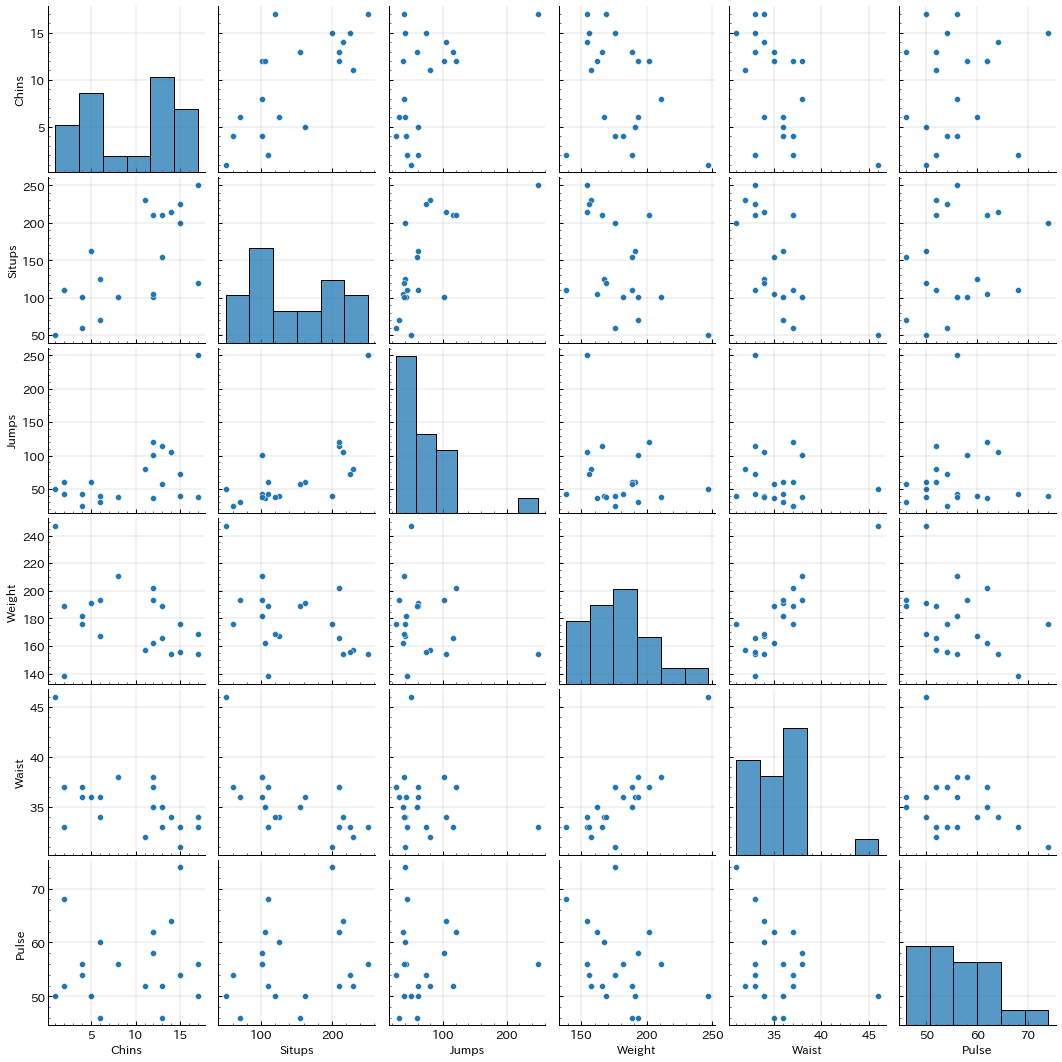

In [3]:
# データの分布確認
sns.pairplot(df)

# モデリングの問題設定

目的変数 : Jumps<br>
説明変数 : その他の変数<br>

# モデルの仮定

### Jumpsのデータの特徴
- 0以上
- 自然数➡数値が大きいため、連続値とみなせると仮定を置く。
### よってガンマ回帰でモデリングを行う。

- ガンマ回帰モデル<br>
  応答変数が正の連続値の場合に使用する。リンク関数には逆関数を使用し、分布族はガンマ分布を仮定する<br>
  
  モデル式<br>
  $y \sim \text{Gamma}(\alpha, \beta)$

  $\ln(y) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p$
  
  解法<br>
  最尤推定法<br>

In [7]:
# ガンマ回帰モデルの構築
y = df["Jumps"]
X = df[["Chins", "Situps", "Weight", "Pulse"]]

model = sm.GLM(y, sm.add_constant(X), family=sm.families.Gamma())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Jumps   No. Observations:                   20
Model:                            GLM   Df Residuals:                       15
Model Family:                   Gamma   Df Model:                            4
Link Function:          inverse_power   Scale:                         0.16891
Method:                          IRLS   Log-Likelihood:                -88.996
Date:                Sat, 06 May 2023   Deviance:                       2.2120
Time:                        20:43:07   Pearson chi2:                     2.53
No. Iterations:                     7   Pseudo R-squ. (CS):             0.7552
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0462      0.018      2.531      0.0

c:\Users\yktkk\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


# 予測結果の確認

真値と予測値のプロット

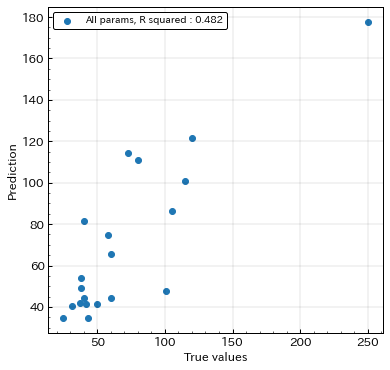

In [9]:
# Prediction
pred1 = result.predict(sm.add_constant(X))

# plot
plt.figure(figsize=(6,6))
plt.scatter(df["Jumps"], pred1, label="All params, R squared : {}".format(round(r2_score(pred1, df["Jumps"]), 3)))
plt.xlabel("True values")
plt.ylabel("Prediction")
plt.legend()

ChinsとJumpsの予測プロット & 分布平均のプロット

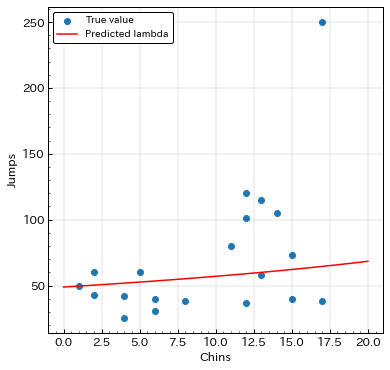

In [31]:
# 平均データを作る
cols = df.columns
# sampling parameter
ave_df = pd.DataFrame({"Chins":np.linspace(0,20,20)})
for c in cols:
    if c!="Chins":
        ave_df[c] = df[c].mean()

X_ = ave_df[["Chins", "Situps", "Weight", "Pulse"]].copy()
X_["const"] = 1.0
X_ = X_[["const", "Chins", "Situps", "Weight", "Pulse"]]

plt.figure(figsize=(6,6))
plt.scatter(df["Chins"], df["Jumps"], label="True value")
plt.plot(ave_df["Chins"], result.predict(X_), label="Predicted lambda", color="red")
plt.xlabel("Chins")
plt.ylabel("Jumps")
plt.legend()